#### Import Tensorflow etc

In [1]:
# Import what we need to train our model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


## Loading the data from the directories and preprocess it for training


In [2]:
# Saving the datasets in variables
train_dir = '/Users/olle/Downloads/final_symbols_split_ttv/train'
val_dir = '/Users/olle/Downloads/final_symbols_split_ttv/val'
test_dir = '/Users/olle/Downloads/final_symbols_split_ttv/test'



#### Setting the parameters for loading the dataset

In [3]:

batch_size = 32 # Determines the number of images processed at once (in one batch) during training.
# Neural networks train more efficiently on mini-batches of data rather than on single images or the entire dataset at once.

# Height and width defines the dimensions to which each image will be resized
img_height = 28
img_width = 28
#  Neural networks require inputs of consistent shape, so images of different sizes must be resized or cropped to match.

#  The choice of image size affects the model's complexity. Smaller images reduce the amount of data the model has to process,
#  leading to faster training times but potentially less detail.

In [4]:
# Load training data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',  # Automatically infer labels from the subdirectory names
    label_mode='categorical', 
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True #The dataset should be shuffled randomly each time it is iterated over during training
)

class_names = train_dataset.class_names  # Automatically inferred from subdirectory names

# Print the classes to verify
print("Classes:", class_names)
print("Number of classes:", len(class_names))

Found 42749 files belonging to 14 classes.
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'divide', 'multiply', 'subtract']
Number of classes: 14


In [5]:
# Load validation data
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 5337 files belonging to 14 classes.


In [6]:
# Load test data
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 5356 files belonging to 14 classes.


### Preprocess and Prepare for Training

In [7]:
# To improve training, it's helpful to normalize pixel values and cache the data for performance.

# Normalize the pixel values to [0, 1] from [0, 255]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Applies normalization_layer to all batches of data
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# The combination of cache() and prefetch() optimizes the data pipeline, improving training and inference speed by minimizing the
# time spent waiting for data.

# cache(): Stores the dataset in memory after the first epoch
# prefetch(): Preloads batches of data into memory while the model is training on the current batch.
# autotune setting: automatically chooses the best prefetching buffer size ( Its a constand provided by tensorflow )

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

##  Building the Model

### Import from keras

In [9]:
from keras import Sequential, Input
from keras.api.layers import *

### Construct the model

This sequential model has multiple layers that process the image data step by step.

In [10]:
model = Sequential([
    Input(shape=(img_height, img_width, 1)),
    # The input layer does not perform any computation; it simply tells the model the shape of incoming images. 1 indicates grayscale images

    Conv2D(32, (3, 3), activation='relu'),
    # This layer applies 16 filters (or kernels) to the input image
    # (3, 3): Each filter is a 3x3 matrix, sliding over the image and detecting specific patterns, like edges.
    # This operation produces 16 new images (one for each filter), each representing a feature map.

    # Think of filters as small windows that detect certain features in the image,
    # such as horizontal or vertical lines. The more filters, the more features it can learn

    # The ReLU (Rectified Linear Unit) activation introduces non-linearity,
    # which allows the network to learn complex patterns by setting all negative values in the feature maps to zero

    MaxPooling2D(pool_size=(2, 2)),
    # Pooling Size (2, 2): This layer takes the maximum value in each 2x2 window, reducing the spatial dimensions by half.
    # For example, if the input to this layer is (28, 28), the output will be (14, 14)
    # The purpose is to help this layer reduce the amount of computation and helps the model focus on the most important features.

    Conv2D(64, (3, 3), activation='relu'),
    # Applies 32 filters of size (3, 3) to the downsampled feature maps from the previous layer,
    # enabling the model to detect more complex patterns by building on the simpler features found by the first layer

    MaxPooling2D(pool_size=(2, 2)),
    # This layer further reduces the spatial dimensions by half again, reducing the overall feature map size.

    Flatten(),
    # Converts the 2D feature maps into a 1D vector, making it ready for the fully connected dense layers.
    # The resulting 1D vector is passed to dense layers for classification.

    Dense(128, activation='relu'),
    # A fully connected layer with 64 neurons, which learns to combine the high-level features detected
    # by the previous layers to make decisions
    # Like before, the ReLU function allows the model to learn more complex patterns by introducing non-linearity.

    Dense(len(class_names), activation='softmax')
    # The final layer, which outputs probabilities for each of the 14 classes (10 digits + 4 operators)
    # Converts the raw scores for each class into probabilities that sum to 1, allowing the network to assign a confidence score to each class.
])

### Compiling the Model

In [11]:
model.compile(
    optimizer='adam',
    # The Adam optimizer adjusts the model's weights to minimize the loss function.
    # It’s adaptive, efficient, and commonly used for deep learning tasks.
    loss='categorical_crossentropy',
    # The loss function measures the difference between the true labels and the predicted probabilities
    metrics=['accuracy']
    # This tracks the accuracy during training and evaluation, showing the proportion of correct predictions.
)

## Train the Model

Training Dataset: helps the model learn patterns in the data.

Validation Dataset: assesses how well the model generalizes to unseen data, acting as a quality check against overfitting.

Epochs: control the training duration, affecting the balance between underfitting and overfitting.

In [12]:
history = model.fit(
    train_dataset,
    # The training dataset is the main set of data used by the model to learn the relationships between inputs and outputs.
    validation_data=val_dataset,
    # Using a validation dataset helps to prevent overfitting by allowing to monitor the model’s performance on data it hasn’t seen before.
    # After each epoch, the model evaluates its performance on the validation dataset,
    # giving an indication of how well it is generalizing to unseen data
    epochs=10
    # With each epoch, the model updates its weights to reduce the loss based on the training data,
    # ideally improving its accuracy and generalization
)

Epoch 1/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7339 - loss: 0.8668 - val_accuracy: 0.9350 - val_loss: 0.1986
Epoch 2/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9428 - loss: 0.1859 - val_accuracy: 0.9638 - val_loss: 0.1142
Epoch 3/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9667 - loss: 0.1076 - val_accuracy: 0.9648 - val_loss: 0.1087
Epoch 4/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9781 - loss: 0.0679 - val_accuracy: 0.9672 - val_loss: 0.1152
Epoch 5/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9839 - loss: 0.0511 - val_accuracy: 0.9749 - val_loss: 0.0825
Epoch 6/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9881 - loss: 0.0346 - val_accuracy: 0.9762 - val_loss: 0.0808
Epoch 7/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9911 - loss: 0.0264 - val_accuracy: 0.9740 - val_loss: 0.1015
Epoch 8/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9936 - loss: 0.

#### Accuracy and loss over epochs to check for signs of overfitting 

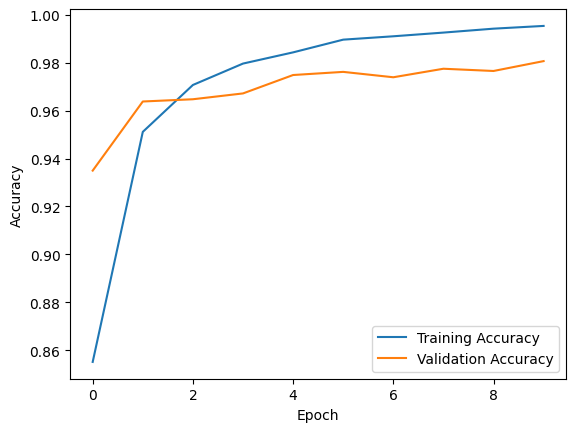

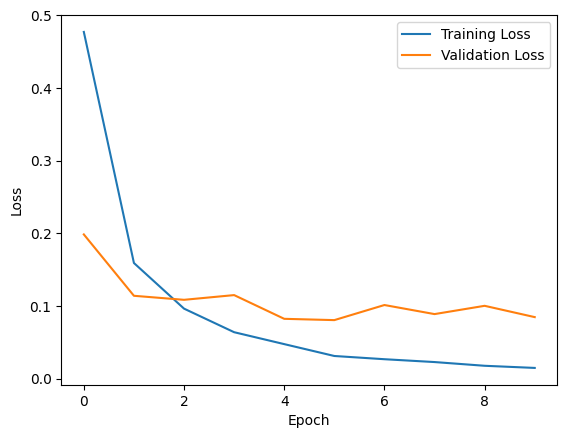

In [13]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Testing the model

In [14]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")
# Observe that the test result was not the same as the result from the last epoch

168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9852 - loss: 0.0737
Test accuracy: 0.9836


## Saving the model

In [16]:
model.save('number_and_symbol_recognizer.keras')